In [1]:
import pandas as pd
import numpy as np
import logging
import pickle
import sys
sys.path.insert(1, '/net/noble/vol1/home/alantmin/hackathon/m6A-calling/')
import m6a_calling


In [2]:
def read_fiber_data(fiber_data_file, buffer=15, subsample=1.0):
    """Read in the fiber data file

    Args:
        fiber_data_file (str): Tabular data generated with ft extract --all

    Returns:
        pandas.DataFrame: pandas dataframe with fiber data
    """
    df = pd.read_csv(fiber_data_file, sep="\t", na_values=[".", ""])
    logging.info(f"Read {len(df)} fibers from {fiber_data_file}")
    for col in ["m6a", "nuc_starts", "nuc_lengths", "ref_m6a"]:
        df[col].fillna("", inplace=True)
        df[col] = df[col].apply(lambda x: np.fromstring(x, sep=",", dtype=np.int64))
    return df

In [3]:
fiberseq_table = read_fiber_data("data/aligned.fiberseq.tbl.gz")

In [ ]:
# Load data from ML matrices 
x = np.load("/net/noble/vol1/home/alantmin/hackathon/m6A-calling/alantmin/data/m6A_train_more_large.npz", allow_pickle=True)

# Load the data
X_train = x["save_data_dict"][()]['X_train']

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_val = x["save_data_dict"][()]['X_val']

# Load the labels
y_train = x["save_data_dict"][()]['y_train']
y_val = x["save_data_dict"][()]['y_val']

# Convert the labels to just 1 dimension
y_train = y_train[:, 0]
train_subread_counts = x["save_data_dict"][()]['train_subread_counts']
val_subread_counts = x["save_data_dict"][()]['val_subread_counts']
train_final_ccss = x["save_data_dict"][()]['train_final_ccss']
val_final_ccss = x["save_data_dict"][()]['val_final_ccss']

train_final_strands = x["save_data_dict"][()]['train_final_strands']
val_final_strands = x["save_data_dict"][()]['val_final_strands']
train_final_m6a_call_positions = x["save_data_dict"][()]['train_final_m6a_call_positions']
val_final_m6a_call_positions = x["save_data_dict"][()]['val_final_m6a_call_positions']


In [56]:
# Load information from fiberseq data into a table
dnase_val_df = pd.DataFrame({"fiber": val_final_ccss})
print(dnase_val_df.shape)

# The fiberseq data has duplicates, so we drop any entries that have duplicate fiber ids
fiberseq_table_dedup = fiberseq_table.drop_duplicates("fiber", keep=False)

# Get the information from mitchell's fiberseq table and match to the ML matrix
dnase_val_df = dnase_val_df.merge(fiberseq_table_dedup, on="fiber", how="left")

# The strandedness inverts the indexing of the strands
# We convert negative strand indexes by fiber_len - location - 1
for i in range(dnase_val_df.shape[0]):
    if dnase_val_df["strand"].iloc[i] == '-':
        fiber_length = dnase_val_df["fiber_length"].iloc[i]
        dnase_val_df.at[i, "m6a"] = fiber_length - dnase_val_df["m6a"].iloc[i] - 1


(757394, 1)


In [57]:
# Get the calls from Anu's ML data matrix call positions
dnase_val_df["anus_m6a"] = val_final_m6a_call_positions

In [ ]:
# Initialize a matrix to store reference values converted from Anu's call positions
anus_ref_m6a = np.zeros(dnase_val_df.shape[0]) - 999

# Identify the reference value associated with the call position
for i in range(dnase_val_df.shape[0]):
    
    # Data is only available currently for positive calls
    if y_val[i, 0] != 0:
        
        # Mitchells m6a is a list of positions of m6a calls in the strand
        mitchellsm6a = dnase_val_df["m6a"].iloc[i]
        
        # Mitchells m6a reference is those positions, but aligned to the
        # reference genome
        mitchellsm6a_ref = dnase_val_df["ref_m6a"].iloc[i]
        
        # Anu's m6a is the position call for a particular spot in the strand
        anus_m6a = dnase_val_df["anus_m6a"].iloc[i]
        
        # Find the position of Anu's call in Mitchell's calls
        anus_ref_m6a_index = np.where(mitchellsm6a == anus_m6a)[0]
        
        # After some error checking, find the reference location of the
        # ML matrix
        if not np.isnan(dnase_val_df.iloc[i, 2]):
            if anus_ref_m6a_index < len(mitchellsm6a_ref):
                if i % 1000 == 0 : print(i)
                anus_ref_m6a[i] = mitchellsm6a_ref[anus_ref_m6a_index]


In [116]:
position_m6a = pd.DataFrame({"chr": dnase_val_df["#ct"], "pos": anus_ref_m6a})

In [120]:
print(X_val.shape)
print(position_m6a.shape)

(757394, 7, 15)
(757394, 2)


In [130]:
# Read in the DNAse data collected from UCSC
DNAse_chr1 = pd.read_csv("data/DNA.HG38wgEncodeRegDnaseUwK562Signal.bw.txt", sep="\t", header=None)
DNAse_chr1.columns = ["chr", "st", "end", "val"]
DNAse_chr1 = DNAse_chr1[DNAse_chr1["chr"] == "chr1"]
DNAse_chr1

/net/noble/vol1/home/alantmin/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,chr,st,end,val
0,chr1,10605,10645.0,0.000000
1,chr1,10785,10805.0,0.000000
2,chr1,10825,10845.0,0.000000
3,chr1,13305,13345.0,0.515631
4,chr1,13945,14005.0,0.000000
...,...,...,...,...
3006504,chr1,248945625,248945645.0,6.703200
3006505,chr1,248945645,248945685.0,7.218830
3006506,chr1,248945685,248945705.0,5.671940
3006507,chr1,248945705,248945725.0,5.156310


In [209]:
"""
This is a method that is pretty fast to go through the
DNAse data and find where the positions from the m6a
calls intersect with the DNAse data. It involves sorting
the positions first and going through sequentially, and 
I think it reduces our time complexity from like n^2 to
n log n + n (nlogn for sorting)
"""

# Initialize a matrix to collect DNAse values
dnase_vals = np.zeros(position_m6a.shape[0])

# Order the position values
positions = position_m6a["pos"].to_numpy()
chroms = position_m6a["chr"].to_numpy()
order = np.argsort(positions)
ordered_positions = positions[order]
ordered_chrom = chroms[order]

# This is how you undo the ordering
undo_order = np.argsort(order)

print(order.shape)
print(undo_order.shape)
print(sum(ordered_positions[undo_order] == positions))

# Counter to leep track of where we are in the DNAse data
encode_counter = 0
encode_start = DNAse_chr1["st"].to_numpy()
encode_end = DNAse_chr1["end"].to_numpy()
encode_vals = DNAse_chr1["val"].to_numpy()

# Go through the ordered positions 
for i, pos in enumerate(ordered_positions):
    
    # Initialize the position to say we don't know a DNAse value
    dnase_vals[i] = -np.inf
    
    # For now, we are only considering DNAse values in Chr1
    if chroms[i] == "chr1":
        
        # Iterate encode_counter until we are ahead of the position
        while(pos > encode_start[encode_counter]):
            encode_counter += 1
        
        # If we are before the end of the position, update DNAse value
        if encode_end[encode_counter] > pos:
            dnase_vals[i] = encode_vals[encode_counter]

# Unsort values to return
dnase_vals = dnase_vals[undo_order]        

(757394,)
(757394,)
757394


In [213]:
# Count how many DNAse values were around
sum(dnase_vals != -np.inf)

70994

In [229]:
# Load the calls from our models

res = np.load("data/m6a_dnase.npz", allow_pickle=True)
cnn = res["val_dict"][()]["val_pred_cnn"]
cnn = cnn[:, 0]
xgb = res["val_dict"][()]["val_pred_xgb"]

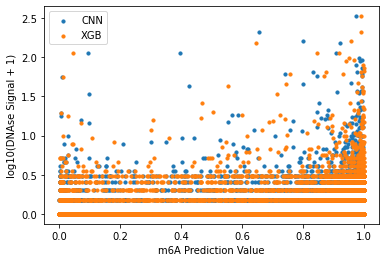

In [241]:
# Plot
noinf = (dnase_vals != -np.inf)
plt.scatter(cnn[noinf], np.log10(dnase_vals[noinf] + 1), s=10, label="CNN")
plt.scatter(xgb[noinf], np.log10(dnase_vals[noinf] + 1), s=10, label="XGB")
plt.legend()
plt.xlabel("m6A Prediction Value")
plt.ylabel("log10(DNAse Signal + 1)")
plt.savefig("DNAse_vs_m6A prediction.pdf")

Text(0, 0.5, 'log10(DNAse + 1)')

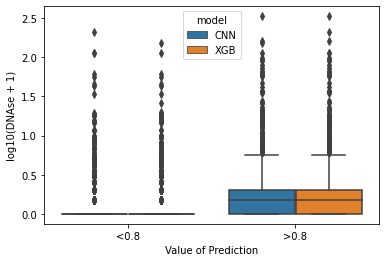

In [268]:
# Plot
plot_dnase = dnase_vals[noinf]
plot_cnn = cnn[noinf]
plot_xgb = xgb[noinf]
cnn_g8 = np.repeat(">0.8", plot_cnn.shape[0])
cnn_g8[plot_cnn < .8] = "<0.8"
xgb_g8 = np.repeat(">0.8", plot_cnn.shape[0])
xgb_g8[plot_xgb < .8] = "<0.8"

df = pd.DataFrame({"DNAse": np.log10(plot_dnase + 1), "CNN": cnn_g8, "XGB": xgb_g8})
df_melt = df.melt(id_vars = "DNAse")
df_melt.columns = ['DNAse', 'model', '>0.8']
df_melt
sns.boxplot(data=df_melt, x=">0.8", y="DNAse", hue="model")
plt.xlabel("Value of Prediction")
plt.ylabel("log10(DNAse + 1)")